In [3]:
# import winsound
# import pyaudio as winsound
import os

import time

import datetime as dt
import urllib
import cdflib as cdf

import pickle

import scipy
import scipy.signal

import pandas as pd

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib inline

from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
from matplotlib.colors import LogNorm,Normalize

from collections import defaultdict
import pytplot
from pytplot import time_datetime
from pyspedas import time_string,time_double,tinterpol

import matplotlib.colors as colors

### Add functions from functions.ipynb, located in folder (str)
import sys as sys
if '/Users/sfordin/Documents/Science-Projects' not in sys.path:
    sys.path.append('/Users/sfordin/Documents/Science-Projects')
if '/Users/sfordin/Plotbot' not in sys.path:
    sys.path.append('/Users/sfordin/Plotbot')

import plotbot

# import warnings

# import ipynb
# from ipynb.fs.defs.functions import (read_mfi,mfi_varsnip,read_3dp,thrdp_varsnip,read_swe,swe_varsnip,
#                                      read_solo_mag,read_solo_swa,solo_mag_varsnip,solo_swa_varsnip,
#                                      highpass,lowpass,bandpass,mva,chunk,resample,
#                                      padded_power,freqs_from_fft_peaks,mva_subintervals,wavelet_spec,boxcar_ave,Wavelet2Go)



In [ ]:
## ⭐️⭐️⭐️ SIMPLIFIED with plot_manager None-handling fix! ⭐️⭐️⭐️
### Jaye's conjunction jambalaya

plotbot.print_manager.show_status = False
plotbot.print_manager.show_debug = False
plotbot.print_manager.show_data_cubby = False

conjumble = [['2020-01-28', '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02'], #E4
['2020-06-06','2020-06-07','2020-06-08','2020-06-09','2020-06-10'], #E5
['2020-09-25','2020-09-30'], #E6
['2021-01-17','2021-01-19','2021-01-20'], #E7
['2021-04-28','2021-04-29'], #E8gr8
['2021-08-08','2021-08-09','2021-08-10','2021-08-11'], #E9
['2021-11-22'], #E10
['2022-02-25'], #E11
['2022-06-02', '2022-06-03'], #E12
['2022-09-04','2022-09-05','2022-09-06'], #E13
['2022-12-12'], #E14
['2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-18'], #E15
['2023-06-21','2023-06-22'], #E16
['2023-09-26', '2023-09-27', '2023-09-28'], #E17
['2023-12-29'], #E18
['2024-03-29', '2024-03-30'], #E19
['2024-06-24','2024-06-25','2024-06-28','2024-06-29','2024-06-30','2024-07-01','2024-07-02','2024-07-03','2024-07-04'], #E20
['2024-09-26','2024-09-28','2024-09-29','2024-09-30','2024-10-01','2024-10-02','2024-10-04'], #E21
['2024-12-23','2024-12-24','2024-12-25'], #E22
['2025-03,19','2025-03-21','2025-03-22','2025-03-23','2025-03-27','2025-03-28'] #E23
]

# Create phi_B BEFORE any data is loaded - no pre-loading needed!
# plot_manager now handles None by converting to empty float64 arrays
phi_B = plotbot.custom_variable(
    'phi_B',
    np.degrees(np.arctan2(plotbot.mag_rtn_4sa.br, plotbot.mag_rtn_4sa.bn)) + 180
)
phi_B.y_label = r'$\phi_B \ (\circ)$'
phi_B.color = 'purple'
phi_B.plot_type = 'scatter'
phi_B.marker_style = 'o'
phi_B.marker_size = 3

print("✅ phi_B created (before any data loaded)!")

plotbot.ploptions.return_figure = False
plotbot.ploptions.display_figure = True

## Loop through encounters
for enc in conjumble:
    for i in range(len(enc)):
        date = enc[i]
        y = int(date[0:4])
        m = int(date[5:7])
        d = int(date[8:10])

        y_str = date[0:4]
        m_str = date[5:7]
        d_str = date[8:10]

        y_f = y
        m_f = m
        d_f = d + 1

        yf_str = str(y_f)
        if m_f > 9:
            mf_str = str(m_f)
        else:
            mf_str = '0{}'.format(m_f)
            
        if d_f > 9:
            df_str = str(d_f)
        else:
            df_str = '0{}'.format(d_f)

        # If next day is out of bounds, change days
        if m in [4,6,9,11]:
            if d == 30:
                m_f += 1
                d_f = 1
                yf_str = str(y_f)
                if m_f > 9:
                    mf_str = str(m_f)
                else:
                    mf_str = '0{}'.format(m_f)
                df_str = '01'

        elif m in [1,2,3,5,7,8,10]:
            if d == 31:
                m_f += 1
                d_f = 1
                yf_str = str(y_f)
                if m_f > 9:
                    mf_str = str(m_f)
                else:
                    mf_str = '0{}'.format(m_f)
                df_str = '01'

        elif m == 12:
            if d == 31:
                y_f += 1
                m_f = 1
                d_f = 1
                yf_str = str(y_f)
                mf_str = '01'
                df_str = '01'
        
        trange = [y_str + '-' + m_str + '-' + d_str + '/00:00:00.000',
                  yf_str + '-' + mf_str + '-' + df_str + '/00:00:00.000']

        # Optional: Clear data cubby each iteration to force fresh downloads
        # plotbot.data_cubby.clear()
        
        # Re-create phi_B if it doesn't exist in the cubby (e.g., after clear())
        # Check if custom_class container exists and has phi_B
        custom_container = plotbot.data_cubby.grab('custom_class')
        phi_B_in_cubby = (custom_container is not None and 
                          hasattr(custom_container, 'variables') and 
                          'phi_B' in custom_container.variables)
        
        if not phi_B_in_cubby:
            # phi_B doesn't exist in cubby, create it
            phi_B = plotbot.custom_variable(
                'phi_B',
                np.degrees(np.arctan2(plotbot.mag_rtn_4sa.br, plotbot.mag_rtn_4sa.bn)) + 180
            )
            phi_B.y_label = r'$\phi_B \ (\circ)$'
            phi_B.color = 'purple'
            phi_B.plot_type = 'scatter'
            phi_B.marker_style = 'o'
            phi_B.marker_size = 3

        # phi_B will auto-update with new br/bn data for this trange!
        plotbot.plotbot(trange, 
                       plotbot.mag_rtn_4sa.bmag, 1, 
                       plotbot.epad.strahl, 2, 
                       phi_B, 3)

In [ ]:
# # Just EPAD alone - NO custom variables
# trange = ['2020-01-28/00:00:00', '2020-01-29/00:00:00']

# plotbot.ploptions.return_figure = True
# plotbot.ploptions.display_figure = True

# fig = plotbot.plotbot(trange, 
#                      plotbot.mag_rtn_4sa.bmag, 1,
#                      plotbot.epad.strahl, 2)
# plt.show()

In [ ]:
# import plotbot
# import numpy as np

# plotbot.print_manager.show_debug = True

# result = np.degrees(np.arctan2(plotbot.mag_rtn_4sa.br, plotbot.mag_rtn_4sa.bn)) + 180
# print(f"SUCCESS! Result: {result}")
# print(f"Result type: {type(result)}")

In [ ]:
# import plotbot
# import numpy as np

# plotbot.print_manager.show_debug = True

# # Test with np (not numpy)
# result = np.degrees(np.arctan2(plotbot.mag_rtn_4sa.br, plotbot.mag_rtn_4sa.bn)) + 180
# print(f"Result: {result}")
# print(f"Result type: {type(result)}")

# phi_B = plotbot.custom_variable(
#     'phi_B',
#     np.degrees(np.arctan2(plotbot.mag_rtn_4sa.br, plotbot.mag_rtn_4sa.bn)) + 180
# )
# print(f"phi_B created: {phi_B}")

In [ ]:
# trange = ['2020-01-28/00:00:00', '2020-01-28/12:00:00']
# # First plot: MAG + EPAD (NO phi_B)
# plotbot.ploptions.display_figure = False
# plotbot.plotbot(trange, 
#                plotbot.mag_rtn_4sa.bmag, 1, 
#                plotbot.epad.strahl, 2)

# # Second plot: Just phi_B
# plotbot.ploptions.display_figure = True  
# plotbot.plotbot(trange, phi_B, 1)

In [ ]:
# import plotbot
# import numpy as np
# import matplotlib.pyplot as plt

# # Turn off debug spam
# plotbot.print_manager.show_debug = False
# plotbot.print_manager.show_cubby = False

# # Simple spectral plot test - NO phi_B, NO custom variables
# trange = ['2020-01-28/00:00:00', '2020-01-28/12:00:00']

# plotbot.ploptions.return_figure = True
# plotbot.ploptions.display_figure = True

# # JUST EPAD - nothing else
# fig = plotbot.plotbot(trange, plotbot.epad.strahl, 1)
# plt.show()

In [ ]:
# ## THIS IS THE ONE WHERE WE FIX CUSTOM VAR⭐️⭐️⭐️⭐️⭐️⭐️⭐️
# ### Jaye's conjunction jambalaya

# plotbot.print_manager.show_status = False
# plotbot.print_manager.show_debug = False
# plotbot.print_manager.show_data_cubby = False

# conjumble = [['2020-01-28', '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02'], #E4
# ['2020-06-06','2020-06-07','2020-06-08','2020-06-09','2020-06-10'], #E5
# ['2020-09-25','2020-09-30'], #E6
# ['2021-01-17','2021-01-19','2021-01-20'], #E7
# ['2021-04-28','2021-04-29'], #E8gr8
# ['2021-08-08','2021-08-09','2021-08-10','2021-08-11'], #E9
# ['2021-11-22'], #E10
# ['2022-02-25'], #E11
# ['2022-06-02', '2022-06-03'], #E12
# ['2022-09-04','2022-09-05','2022-09-06'], #E13
# ['2022-12-12'], #E14
# ['2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-18'], #E15
# ['2023-06-21','2023-06-22'], #E16
# ['2023-09-26', '2023-09-27', '2023-09-28'], #E17
# ['2023-12-29'], #E18
# ['2024-03-29', '2024-03-30'], #E19
# ['2024-06-24','2024-06-25','2024-06-28','2024-06-29','2024-06-30','2024-07-01','2024-07-02','2024-07-03','2024-07-04'], #E20
# ['2024-09-26','2024-09-28','2024-09-29','2024-09-30','2024-10-01','2024-10-02','2024-10-04'], #E21
# ['2024-12-23','2024-12-24','2024-12-25'], #E22
# ['2025-03,19','2025-03-21','2025-03-22','2025-03-23','2025-03-27','2025-03-28'] #E23
# ]

# # PRE-LOAD data for first date to create phi_B
# first_date = conjumble[0][0]
# init_trange = [first_date + '/00:00:00', first_date + '/12:00:00']

# plotbot.ploptions.display_figure = False
# plotbot.plotbot(init_trange, plotbot.mag_rtn_4sa.bmag, 1)

# # NOW create phi_B with loaded data - NO LAMBDA!
# phi_B = plotbot.custom_variable(
#     'phi_B',
#     np.degrees(np.arctan2(plotbot.mag_rtn_4sa.br, plotbot.mag_rtn_4sa.bn)) + 180
# )
# phi_B.y_label = r'$\phi_B \ (\circ)$'
# phi_B.color = 'purple'
# phi_B.plot_type = 'scatter'
# phi_B.marker_style = 'o'
# phi_B.marker_size = 3

# print("✅ phi_B created!")

# ## Loop through encounters
# for enc in conjumble:
#     for i in range(len(enc)):
#         date = enc[i]
#         y = int(date[0:4])
#         m = int(date[5:7])
#         d = int(date[8:10])

#         y_str = date[0:4]
#         m_str = date[5:7]
#         d_str = date[8:10]

#         y_f = y
#         m_f = m
#         d_f = d + 1

#         yf_str = str(y_f)
#         if m_f > 9:
#             mf_str = str(m_f)
#         else:
#             mf_str = '0{}'.format(m_f)
            
#         if d_f > 9:
#             df_str = str(d_f)
#         else:
#             df_str = '0{}'.format(d_f)

#         # If next day is out of bounds, change days
#         if m in [4,6,9,11]:
#             if d == 30:
#                 m_f += 1
#                 d_f = 1
#                 yf_str = str(y_f)
#                 if m_f > 9:
#                     mf_str = str(m_f)
#                 else:
#                     mf_str = '0{}'.format(m_f)
#                 df_str = '01'

#         elif m in [1,2,3,5,7,8,10]:
#             if d == 31:
#                 m_f += 1
#                 d_f = 1
#                 yf_str = str(y_f)
#                 if m_f > 9:
#                     mf_str = str(m_f)
#                 else:
#                     mf_str = '0{}'.format(m_f)
#                 df_str = '01'

#         elif m == 12:
#             if d == 31:
#                 y_f += 1
#                 m_f = 1
#                 d_f = 1
#                 yf_str = str(y_f)
#                 mf_str = '01'
#                 df_str = '01'
        
#         trange = [y_str + '-' + m_str + '-' + d_str + '/00:00:00.000',
#                   yf_str + '-' + mf_str + '-' + df_str + '/00:00:00.000']

#         plotbot.ploptions.return_figure = False
#         plotbot.ploptions.display_figure = True

#         # phi_B will auto-update with new br/bn data for this trange!
#         plotbot.plotbot(trange, 
#                        plotbot.mag_rtn_4sa.bmag, 1, 
#                        plotbot.epad.strahl, 2, 
#                        phi_B, 3)

In [ ]:
# ## THIS IS THE ONE WEHERE WE ATTEMPT CUSTOM VAR⭐️⭐️⭐️⭐️⭐️⭐️⭐️
# ### Jaye's conjunction jambalaya

# # VERIFY numpy is working
# print(f"np is: {np}")
# print(f"np.arctan2 is: {np.arctan2}")

# plotbot.print_manager.show_status = False
# plotbot.print_manager.show_debug = False
# plotbot.print_manager.show_data_cubby = True

# conjumble = [['2020-01-28', '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02'], #E4
# ['2020-06-06','2020-06-07','2020-06-08','2020-06-09','2020-06-10'], #E5
# ['2020-09-25','2020-09-30'], #E6
# ['2021-01-17','2021-01-19','2021-01-20'], #E7
# ['2021-04-28','2021-04-29'], #E8gr8
# ['2021-08-08','2021-08-09','2021-08-10','2021-08-11'], #E9
# ['2021-11-22'], #E10
# ['2022-02-25'], #E11
# ['2022-06-02', '2022-06-03'], #E12
# ['2022-09-04','2022-09-05','2022-09-06'], #E13
# ['2022-12-12'], #E14
# ['2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-18'], #E15
# ['2023-06-21','2023-06-22'], #E16
# ['2023-09-26', '2023-09-27', '2023-09-28'], #E17
# ['2023-12-29'], #E18
# ['2024-03-29', '2024-03-30'], #E19
# ['2024-06-24','2024-06-25','2024-06-28','2024-06-29','2024-06-30','2024-07-01','2024-07-02','2024-07-03','2024-07-04'], #E20
# ['2024-09-26','2024-09-28','2024-09-29','2024-09-30','2024-10-01','2024-10-02','2024-10-04'], #E21
# ['2024-12-23','2024-12-24','2024-12-25'], #E22
# ['2025-03,19','2025-03-21','2025-03-22','2025-03-23','2025-03-27','2025-03-28'] #E23
# ]


# # CREATE PHI_B CUSTOM VARIABLE ONCE - BEFORE THE LOOP
# phi_B = plotbot.custom_variable(
#     'phi_B',
#     lambda: np.degrees(np.arctan2(plotbot.mag_rtn_4sa.br, plotbot.mag_rtn_4sa.bn)) + 180
# )
# phi_B.y_label = r'$\phi_B \ (\circ)$'
# phi_B.color = 'purple'
# phi_B.plot_type = 'scatter'
# phi_B.marker_style = 'o'
# phi_B.marker_size = 3
# phi_B.line_style = ''  # Empty string instead of 'None'

# # DEBUG: Print what phi_B thinks it is
# print("="*60)
# print("PHI_B ATTRIBUTES:")
# print("="*60)
# print(f"  phi_B.plot_type:           {phi_B.plot_type}")
# print(f"  phi_B.plot_config.plot_type: {phi_B.plot_config.plot_type}")
# print(f"  phi_B.class_name:          {phi_B.class_name}")
# print(f"  phi_B.subclass_name:       {phi_B.subclass_name}")
# print(f"  phi_B.marker:              {phi_B.marker}")
# print(f"  phi_B.marker_size:         {phi_B.marker_size}")
# print(f"  phi_B.color:               {phi_B.color}")
# print(f"  phi_B.line_style:          {getattr(phi_B, 'line_style', 'NOT SET')}")
# print("="*60)

# ## Loop through encounters
# for enc in conjumble:
#     for i in range(len(enc)):
#         date = enc[i]
#         y = int(date[0:4])
#         m = int(date[5:7])
#         d = int(date[8:10])

#         y_str = date[0:4]
#         m_str = date[5:7]
#         d_str = date[8:10]

#         y_f = y
#         m_f = m
#         d_f = d + 1

#         yf_str = str(y_f)
#         if m_f > 9:
#             mf_str = str(m_f)
#         else:
#             mf_str = '0{}'.format(m_f)
            
#         if d_f > 9:
#             df_str = str(d_f)
#         else:
#             df_str = '0{}'.format(d_f)

#         # If next day is out of bounds, change days
#         if m in [4,6,9,11]:
#             if d == 30:
#                 m_f += 1
#                 d_f = 1
#                 yf_str = str(y_f)
#                 if m_f > 9:
#                     mf_str = str(m_f)
#                 else:
#                     mf_str = '0{}'.format(m_f)
#                 df_str = '01'

#         elif m in [1,2,3,5,7,8,10]:
#             if d == 31:
#                 m_f += 1
#                 d_f = 1
#                 yf_str = str(y_f)
#                 if m_f > 9:
#                     mf_str = str(m_f)
#                 else:
#                     mf_str = '0{}'.format(m_f)
#                 df_str = '01'

#         elif m == 12:
#             if d == 31:
#                 y_f += 1
#                 m_f = 1
#                 d_f = 1
#                 yf_str = str(y_f)
#                 mf_str = '01'
#                 df_str = '01'
        
#         trange = [y_str + '-' + m_str + '-' + d_str + '/00:00:00.000',
#                   yf_str + '-' + mf_str + '-' + df_str + '/00:00:00.000']

#         plotbot.ploptions.return_figure = False
#         plotbot.ploptions.display_figure = True

#         # phi_B automatically uses the clipped br and bn for this trange!
#         plotbot.plotbot(trange, 
#                        plotbot.mag_rtn_4sa.bmag, 1, 
#                        plotbot.epad.strahl, 2, 
#                        phi_B, 3)
        
#         # After the first plotbot() call in the loop
#         print(f"phi_B plot_type when plotting: {phi_B.plot_type}")
#         print(f"phi_B plot_config.plot_type: {phi_B.plot_config.plot_type}")

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubby ===
[CUBBY] GRAB CALLER: /Users/robertalexander/GitHub/Plotbot/plotbot/plotbot_main.py:389
[CUBBY] GRAB SUCCESS - Retrieved mag_rtn_4sa with type <class 'plotbot.data_classes.psp_mag_rtn_4sa.mag_rtn_4sa_class'>
[CUBBY] [CUBBY_GRAB_RETURN_STATE] Object ID 13061975952 for key 'mag_rtn_4sa'. dt_len: 5140772, min: 2020-01-28T00:00:00.074993408, max: 2020-09-30T23:59:59.833505024
[CUBBY] GRAB OUTPUT - datetime_array type=ndarray, elem_type=datetime64, shape=(5140772,), range=2020-01-28T00:00:00.074993 to 2020-09-30T23:59:59.833505
[CUBBY] GRAB OUTPUT - raw_data keys=['bt', 'pmag', 'bmag', 'bn', 'br', 'all'] | bt: type=ndarray, shape=(5140772,) | pmag: type=ndarray, shape=(5140772,) | bmag: type=ndarray, shape=(5140772,) | bn: type=ndarray, shape=(5140772,) | br: type=ndarray, shape=(5140772,) | all(list): len=3, elem_shape=(5140772,)
[CUBBY] === End Retrieval Debug (LEAVING DATA CUBBY)===

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubb

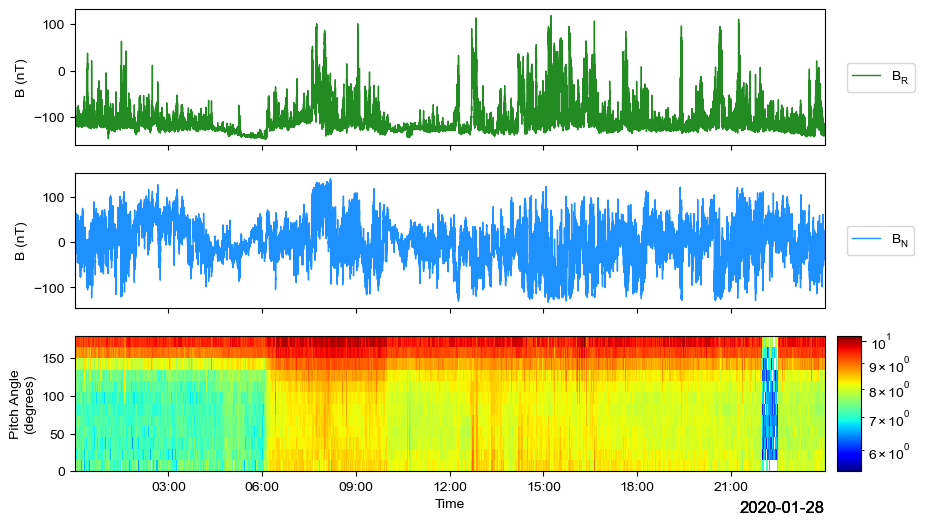

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubby ===
[CUBBY] GRAB CALLER: /Users/robertalexander/GitHub/Plotbot/plotbot/plotbot_main.py:389
[CUBBY] GRAB SUCCESS - Retrieved mag_rtn_4sa with type <class 'plotbot.data_classes.psp_mag_rtn_4sa.mag_rtn_4sa_class'>
[CUBBY] [CUBBY_GRAB_RETURN_STATE] Object ID 13061975952 for key 'mag_rtn_4sa'. dt_len: 5140772, min: 2020-01-28T00:00:00.074993408, max: 2020-09-30T23:59:59.833505024
[CUBBY] GRAB OUTPUT - datetime_array type=ndarray, elem_type=datetime64, shape=(5140772,), range=2020-01-28T00:00:00.074993 to 2020-09-30T23:59:59.833505
[CUBBY] GRAB OUTPUT - raw_data keys=['bt', 'pmag', 'bmag', 'bn', 'br', 'all'] | bt: type=ndarray, shape=(5140772,) | pmag: type=ndarray, shape=(5140772,) | bmag: type=ndarray, shape=(5140772,) | bn: type=ndarray, shape=(5140772,) | br: type=ndarray, shape=(5140772,) | all(list): len=3, elem_shape=(5140772,)
[CUBBY] === End Retrieval Debug (LEAVING DATA CUBBY)===

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubb

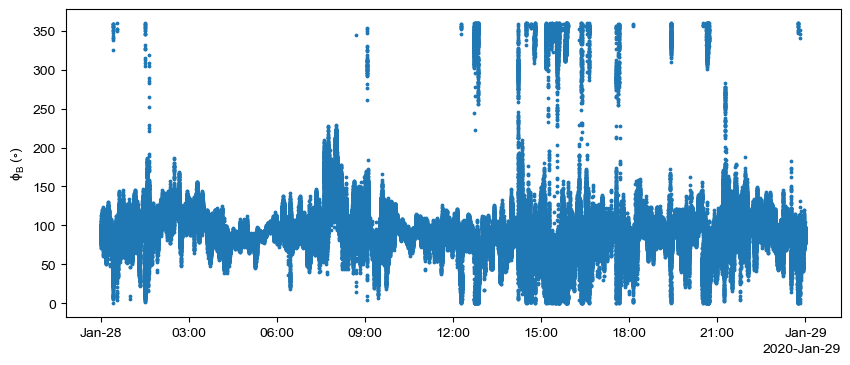

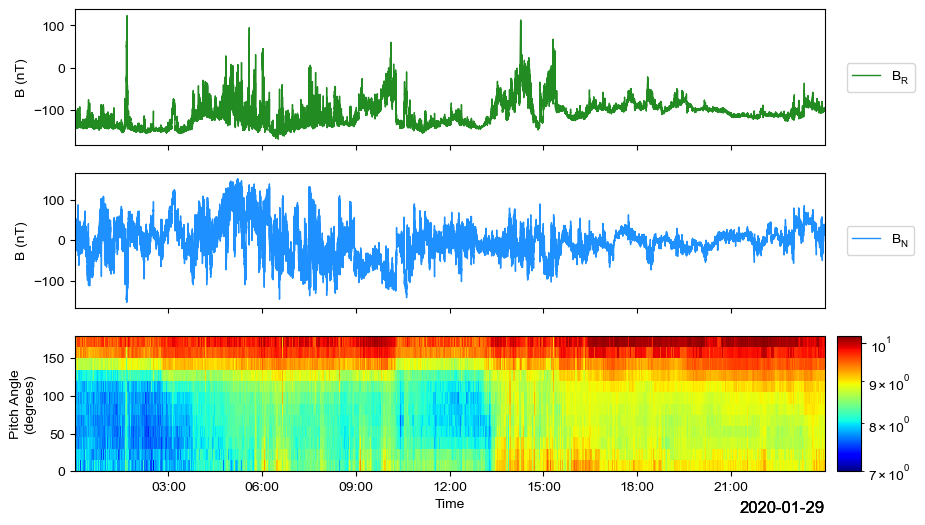

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubby ===
[CUBBY] GRAB CALLER: /Users/robertalexander/GitHub/Plotbot/plotbot/plotbot_main.py:389
[CUBBY] GRAB SUCCESS - Retrieved mag_rtn_4sa with type <class 'plotbot.data_classes.psp_mag_rtn_4sa.mag_rtn_4sa_class'>
[CUBBY] [CUBBY_GRAB_RETURN_STATE] Object ID 13061975952 for key 'mag_rtn_4sa'. dt_len: 5140772, min: 2020-01-28T00:00:00.074993408, max: 2020-09-30T23:59:59.833505024
[CUBBY] GRAB OUTPUT - datetime_array type=ndarray, elem_type=datetime64, shape=(5140772,), range=2020-01-28T00:00:00.074993 to 2020-09-30T23:59:59.833505
[CUBBY] GRAB OUTPUT - raw_data keys=['bt', 'pmag', 'bmag', 'bn', 'br', 'all'] | bt: type=ndarray, shape=(5140772,) | pmag: type=ndarray, shape=(5140772,) | bmag: type=ndarray, shape=(5140772,) | bn: type=ndarray, shape=(5140772,) | br: type=ndarray, shape=(5140772,) | all(list): len=3, elem_shape=(5140772,)
[CUBBY] === End Retrieval Debug (LEAVING DATA CUBBY)===

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubb

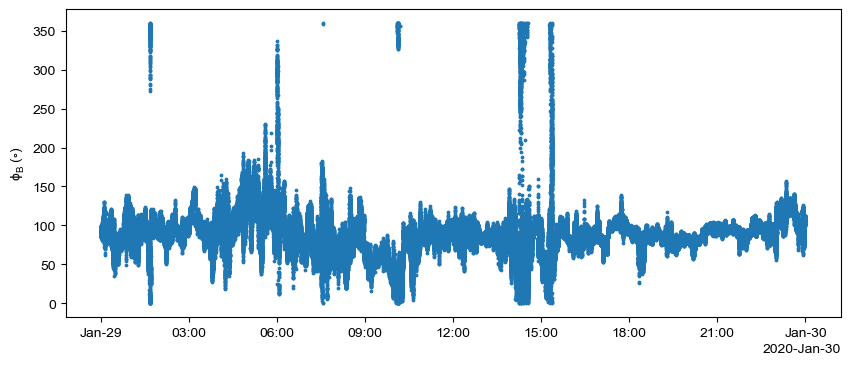

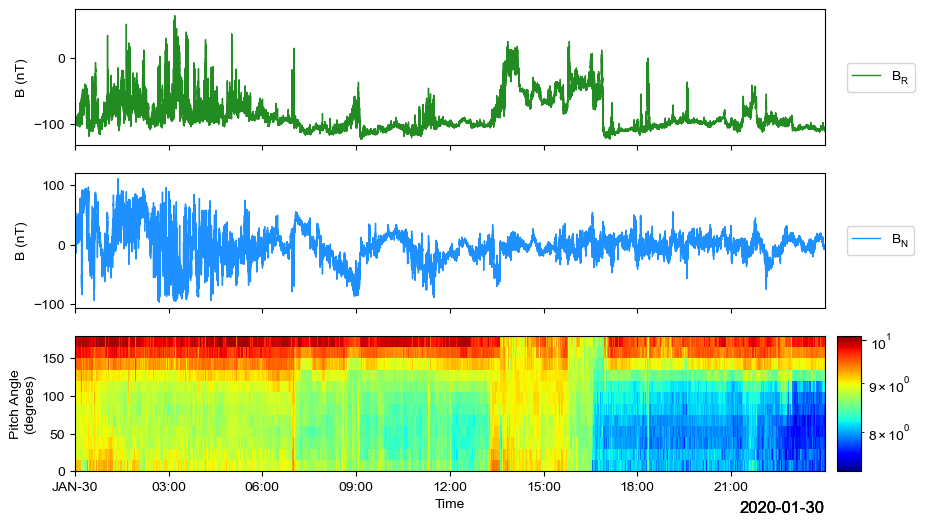

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubby ===
[CUBBY] GRAB CALLER: /Users/robertalexander/GitHub/Plotbot/plotbot/plotbot_main.py:389
[CUBBY] GRAB SUCCESS - Retrieved mag_rtn_4sa with type <class 'plotbot.data_classes.psp_mag_rtn_4sa.mag_rtn_4sa_class'>
[CUBBY] [CUBBY_GRAB_RETURN_STATE] Object ID 13061975952 for key 'mag_rtn_4sa'. dt_len: 5140772, min: 2020-01-28T00:00:00.074993408, max: 2020-09-30T23:59:59.833505024
[CUBBY] GRAB OUTPUT - datetime_array type=ndarray, elem_type=datetime64, shape=(5140772,), range=2020-01-28T00:00:00.074993 to 2020-09-30T23:59:59.833505
[CUBBY] GRAB OUTPUT - raw_data keys=['bt', 'pmag', 'bmag', 'bn', 'br', 'all'] | bt: type=ndarray, shape=(5140772,) | pmag: type=ndarray, shape=(5140772,) | bmag: type=ndarray, shape=(5140772,) | bn: type=ndarray, shape=(5140772,) | br: type=ndarray, shape=(5140772,) | all(list): len=3, elem_shape=(5140772,)
[CUBBY] === End Retrieval Debug (LEAVING DATA CUBBY)===

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubb

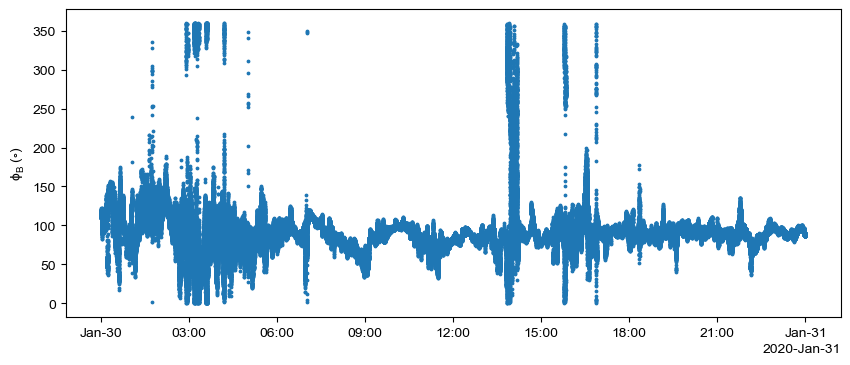

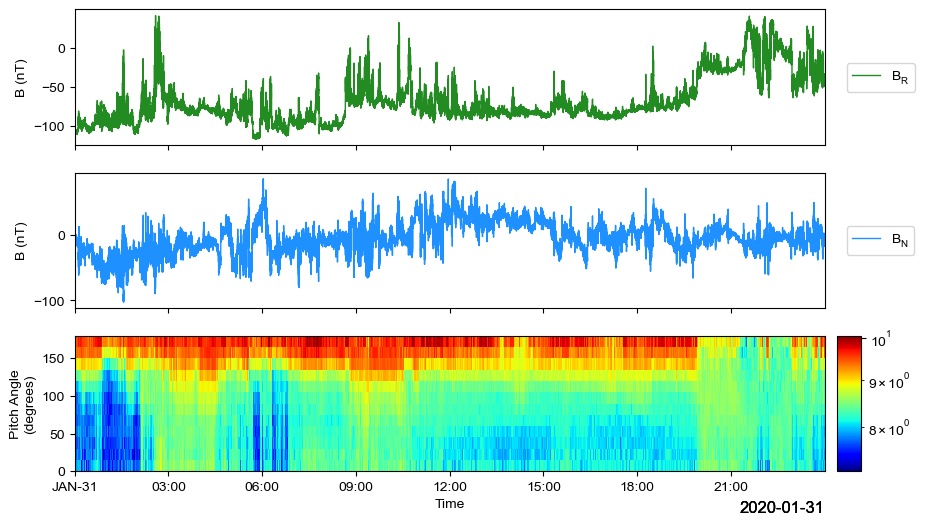

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubby ===
[CUBBY] GRAB CALLER: /Users/robertalexander/GitHub/Plotbot/plotbot/plotbot_main.py:389
[CUBBY] GRAB SUCCESS - Retrieved mag_rtn_4sa with type <class 'plotbot.data_classes.psp_mag_rtn_4sa.mag_rtn_4sa_class'>
[CUBBY] [CUBBY_GRAB_RETURN_STATE] Object ID 13061975952 for key 'mag_rtn_4sa'. dt_len: 5140772, min: 2020-01-28T00:00:00.074993408, max: 2020-09-30T23:59:59.833505024
[CUBBY] GRAB OUTPUT - datetime_array type=ndarray, elem_type=datetime64, shape=(5140772,), range=2020-01-28T00:00:00.074993 to 2020-09-30T23:59:59.833505
[CUBBY] GRAB OUTPUT - raw_data keys=['bt', 'pmag', 'bmag', 'bn', 'br', 'all'] | bt: type=ndarray, shape=(5140772,) | pmag: type=ndarray, shape=(5140772,) | bmag: type=ndarray, shape=(5140772,) | bn: type=ndarray, shape=(5140772,) | br: type=ndarray, shape=(5140772,) | all(list): len=3, elem_shape=(5140772,)
[CUBBY] === End Retrieval Debug (LEAVING DATA CUBBY)===

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubb

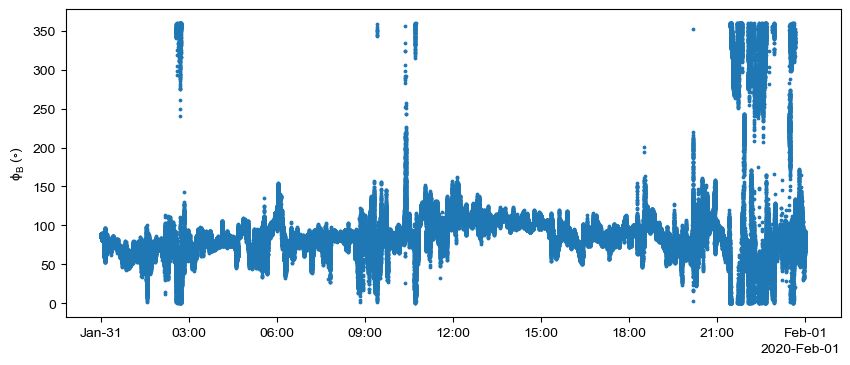

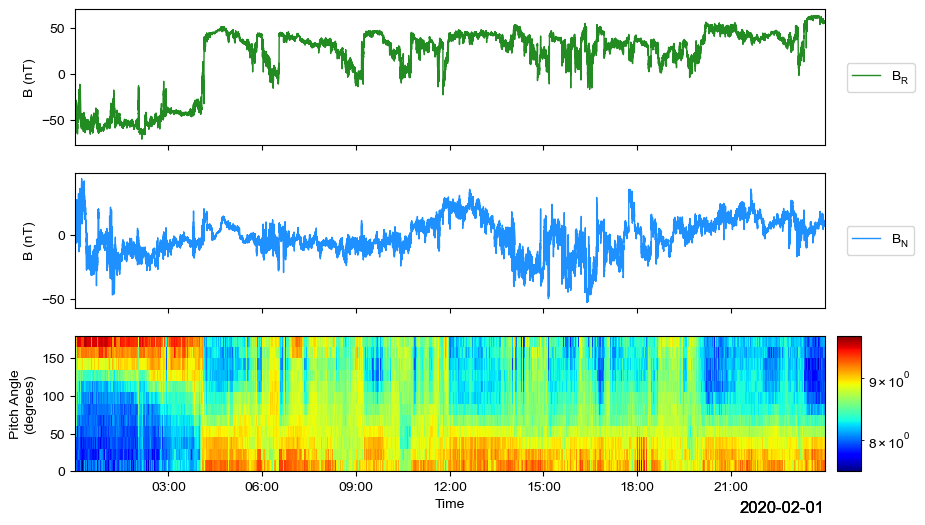

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubby ===
[CUBBY] GRAB CALLER: /Users/robertalexander/GitHub/Plotbot/plotbot/plotbot_main.py:389
[CUBBY] GRAB SUCCESS - Retrieved mag_rtn_4sa with type <class 'plotbot.data_classes.psp_mag_rtn_4sa.mag_rtn_4sa_class'>
[CUBBY] [CUBBY_GRAB_RETURN_STATE] Object ID 13061975952 for key 'mag_rtn_4sa'. dt_len: 5140772, min: 2020-01-28T00:00:00.074993408, max: 2020-09-30T23:59:59.833505024
[CUBBY] GRAB OUTPUT - datetime_array type=ndarray, elem_type=datetime64, shape=(5140772,), range=2020-01-28T00:00:00.074993 to 2020-09-30T23:59:59.833505
[CUBBY] GRAB OUTPUT - raw_data keys=['bt', 'pmag', 'bmag', 'bn', 'br', 'all'] | bt: type=ndarray, shape=(5140772,) | pmag: type=ndarray, shape=(5140772,) | bmag: type=ndarray, shape=(5140772,) | bn: type=ndarray, shape=(5140772,) | br: type=ndarray, shape=(5140772,) | all(list): len=3, elem_shape=(5140772,)
[CUBBY] === End Retrieval Debug (LEAVING DATA CUBBY)===

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubb

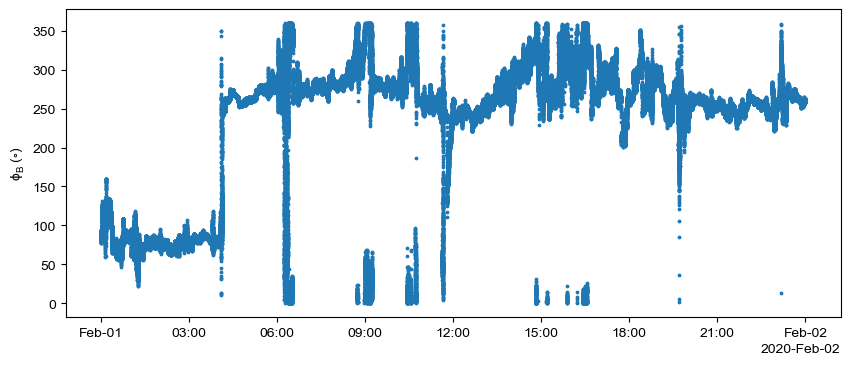

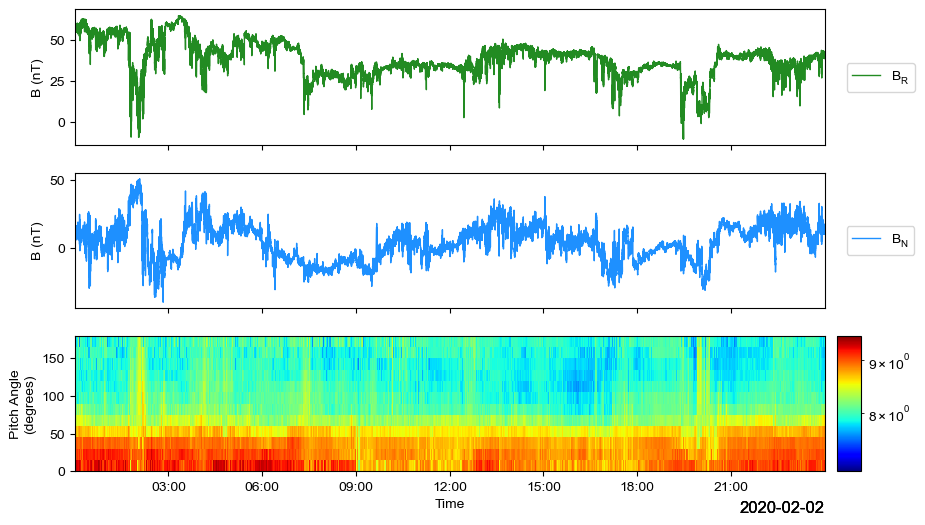

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubby ===
[CUBBY] GRAB CALLER: /Users/robertalexander/GitHub/Plotbot/plotbot/plotbot_main.py:389
[CUBBY] GRAB SUCCESS - Retrieved mag_rtn_4sa with type <class 'plotbot.data_classes.psp_mag_rtn_4sa.mag_rtn_4sa_class'>
[CUBBY] [CUBBY_GRAB_RETURN_STATE] Object ID 13061975952 for key 'mag_rtn_4sa'. dt_len: 5140772, min: 2020-01-28T00:00:00.074993408, max: 2020-09-30T23:59:59.833505024
[CUBBY] GRAB OUTPUT - datetime_array type=ndarray, elem_type=datetime64, shape=(5140772,), range=2020-01-28T00:00:00.074993 to 2020-09-30T23:59:59.833505
[CUBBY] GRAB OUTPUT - raw_data keys=['bt', 'pmag', 'bmag', 'bn', 'br', 'all'] | bt: type=ndarray, shape=(5140772,) | pmag: type=ndarray, shape=(5140772,) | bmag: type=ndarray, shape=(5140772,) | bn: type=ndarray, shape=(5140772,) | br: type=ndarray, shape=(5140772,) | all(list): len=3, elem_shape=(5140772,)
[CUBBY] === End Retrieval Debug (LEAVING DATA CUBBY)===

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubb

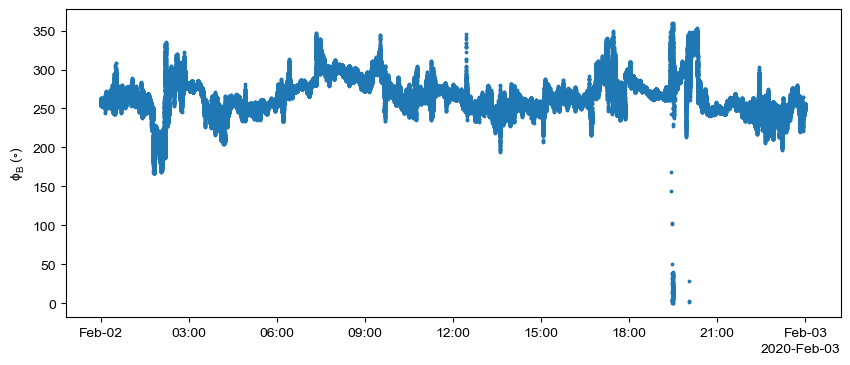

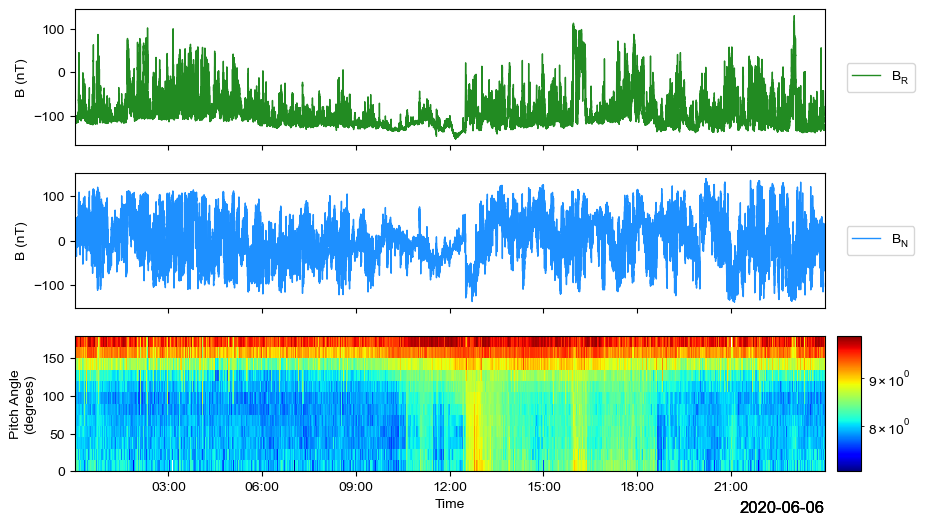

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubby ===
[CUBBY] GRAB CALLER: /Users/robertalexander/GitHub/Plotbot/plotbot/plotbot_main.py:389
[CUBBY] GRAB SUCCESS - Retrieved mag_rtn_4sa with type <class 'plotbot.data_classes.psp_mag_rtn_4sa.mag_rtn_4sa_class'>
[CUBBY] [CUBBY_GRAB_RETURN_STATE] Object ID 13061975952 for key 'mag_rtn_4sa'. dt_len: 5140772, min: 2020-01-28T00:00:00.074993408, max: 2020-09-30T23:59:59.833505024
[CUBBY] GRAB OUTPUT - datetime_array type=ndarray, elem_type=datetime64, shape=(5140772,), range=2020-01-28T00:00:00.074993 to 2020-09-30T23:59:59.833505
[CUBBY] GRAB OUTPUT - raw_data keys=['bt', 'pmag', 'bmag', 'bn', 'br', 'all'] | bt: type=ndarray, shape=(5140772,) | pmag: type=ndarray, shape=(5140772,) | bmag: type=ndarray, shape=(5140772,) | bn: type=ndarray, shape=(5140772,) | br: type=ndarray, shape=(5140772,) | all(list): len=3, elem_shape=(5140772,)
[CUBBY] === End Retrieval Debug (LEAVING DATA CUBBY)===

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubb

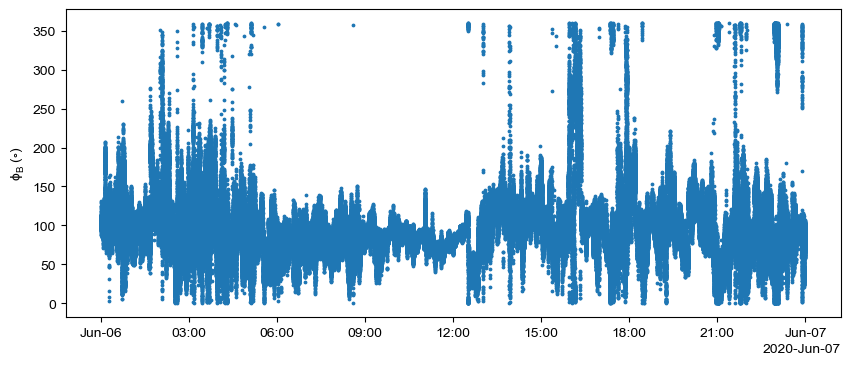

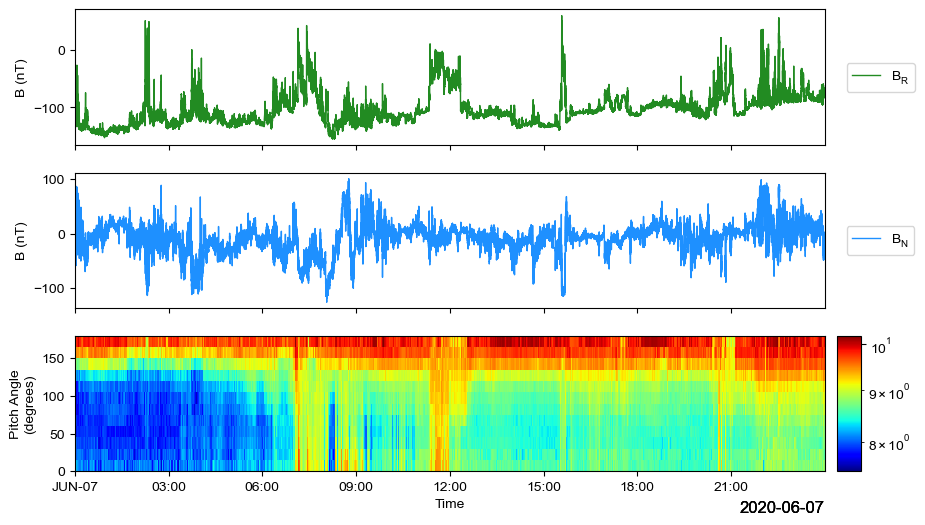

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubby ===
[CUBBY] GRAB CALLER: /Users/robertalexander/GitHub/Plotbot/plotbot/plotbot_main.py:389
[CUBBY] GRAB SUCCESS - Retrieved mag_rtn_4sa with type <class 'plotbot.data_classes.psp_mag_rtn_4sa.mag_rtn_4sa_class'>
[CUBBY] [CUBBY_GRAB_RETURN_STATE] Object ID 13061975952 for key 'mag_rtn_4sa'. dt_len: 5140772, min: 2020-01-28T00:00:00.074993408, max: 2020-09-30T23:59:59.833505024
[CUBBY] GRAB OUTPUT - datetime_array type=ndarray, elem_type=datetime64, shape=(5140772,), range=2020-01-28T00:00:00.074993 to 2020-09-30T23:59:59.833505
[CUBBY] GRAB OUTPUT - raw_data keys=['bt', 'pmag', 'bmag', 'bn', 'br', 'all'] | bt: type=ndarray, shape=(5140772,) | pmag: type=ndarray, shape=(5140772,) | bmag: type=ndarray, shape=(5140772,) | bn: type=ndarray, shape=(5140772,) | br: type=ndarray, shape=(5140772,) | all(list): len=3, elem_shape=(5140772,)
[CUBBY] === End Retrieval Debug (LEAVING DATA CUBBY)===

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubb

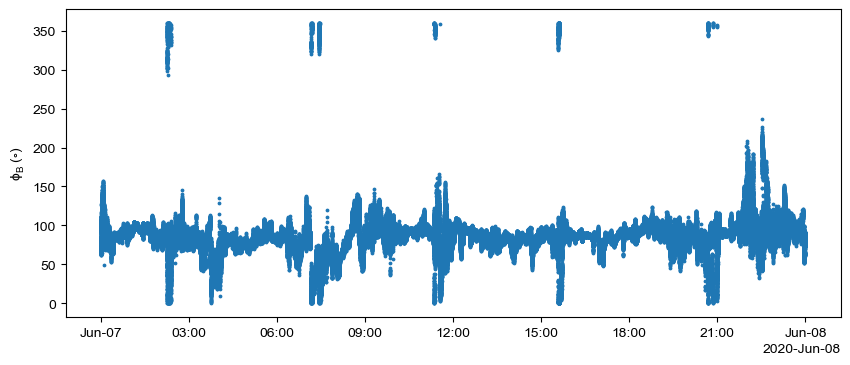

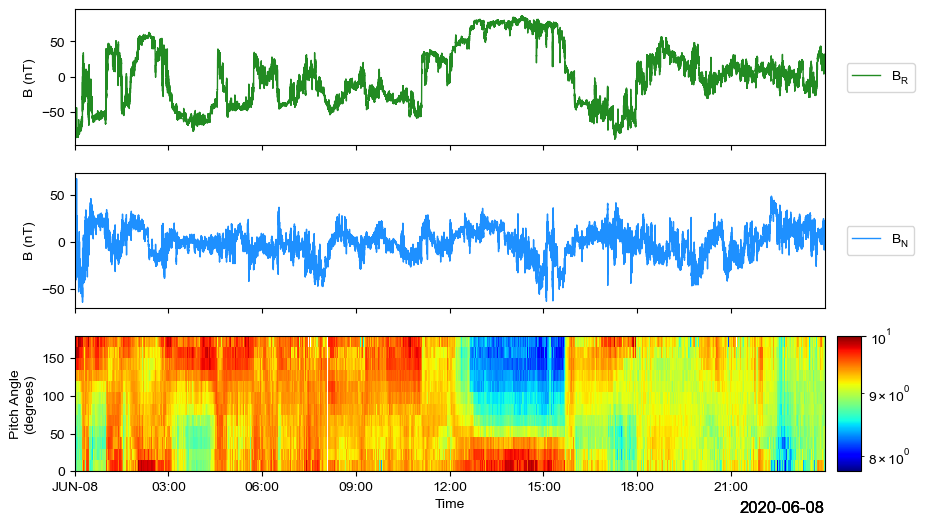

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubby ===
[CUBBY] GRAB CALLER: /Users/robertalexander/GitHub/Plotbot/plotbot/plotbot_main.py:389
[CUBBY] GRAB SUCCESS - Retrieved mag_rtn_4sa with type <class 'plotbot.data_classes.psp_mag_rtn_4sa.mag_rtn_4sa_class'>
[CUBBY] [CUBBY_GRAB_RETURN_STATE] Object ID 13061975952 for key 'mag_rtn_4sa'. dt_len: 5140772, min: 2020-01-28T00:00:00.074993408, max: 2020-09-30T23:59:59.833505024
[CUBBY] GRAB OUTPUT - datetime_array type=ndarray, elem_type=datetime64, shape=(5140772,), range=2020-01-28T00:00:00.074993 to 2020-09-30T23:59:59.833505
[CUBBY] GRAB OUTPUT - raw_data keys=['bt', 'pmag', 'bmag', 'bn', 'br', 'all'] | bt: type=ndarray, shape=(5140772,) | pmag: type=ndarray, shape=(5140772,) | bmag: type=ndarray, shape=(5140772,) | bn: type=ndarray, shape=(5140772,) | br: type=ndarray, shape=(5140772,) | all(list): len=3, elem_shape=(5140772,)
[CUBBY] === End Retrieval Debug (LEAVING DATA CUBBY)===

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubb

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x104c01280>>
Traceback (most recent call last):
  File "/Users/robertalexander/micromamba/envs/plotbot_micromamba/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


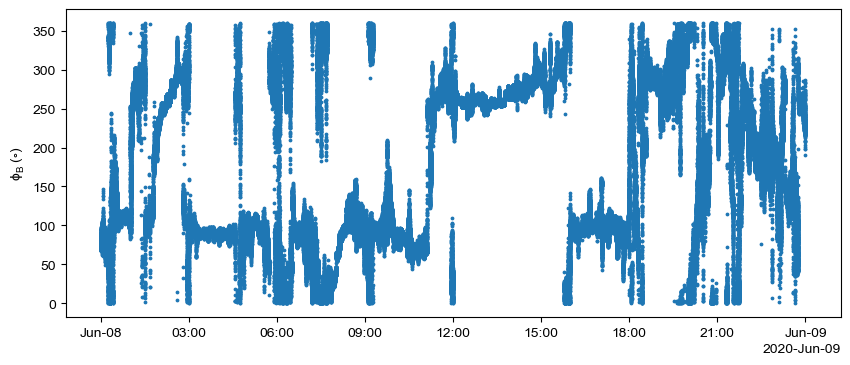

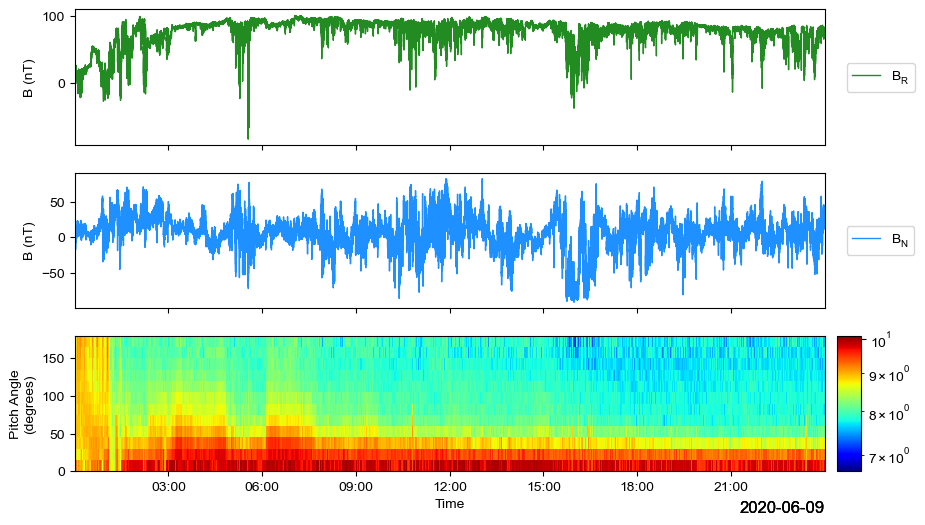

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubby ===
[CUBBY] GRAB CALLER: /Users/robertalexander/GitHub/Plotbot/plotbot/plotbot_main.py:389
[CUBBY] GRAB SUCCESS - Retrieved mag_rtn_4sa with type <class 'plotbot.data_classes.psp_mag_rtn_4sa.mag_rtn_4sa_class'>
[CUBBY] [CUBBY_GRAB_RETURN_STATE] Object ID 13061975952 for key 'mag_rtn_4sa'. dt_len: 5140772, min: 2020-01-28T00:00:00.074993408, max: 2020-09-30T23:59:59.833505024
[CUBBY] GRAB OUTPUT - datetime_array type=ndarray, elem_type=datetime64, shape=(5140772,), range=2020-01-28T00:00:00.074993 to 2020-09-30T23:59:59.833505
[CUBBY] GRAB OUTPUT - raw_data keys=['bt', 'pmag', 'bmag', 'bn', 'br', 'all'] | bt: type=ndarray, shape=(5140772,) | pmag: type=ndarray, shape=(5140772,) | bmag: type=ndarray, shape=(5140772,) | bn: type=ndarray, shape=(5140772,) | br: type=ndarray, shape=(5140772,) | all(list): len=3, elem_shape=(5140772,)
[CUBBY] === End Retrieval Debug (LEAVING DATA CUBBY)===

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubb

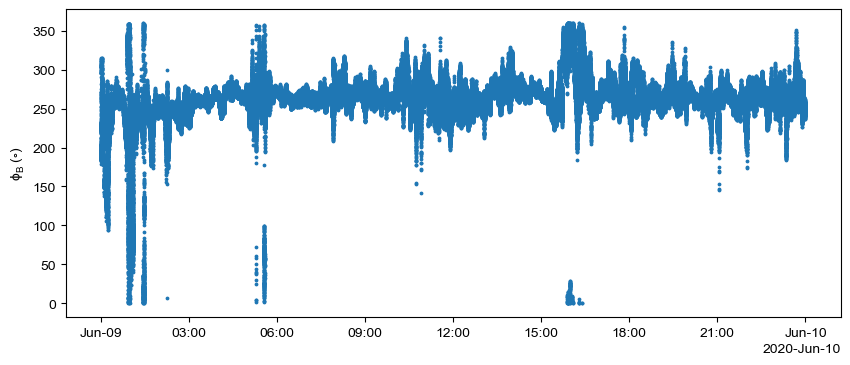

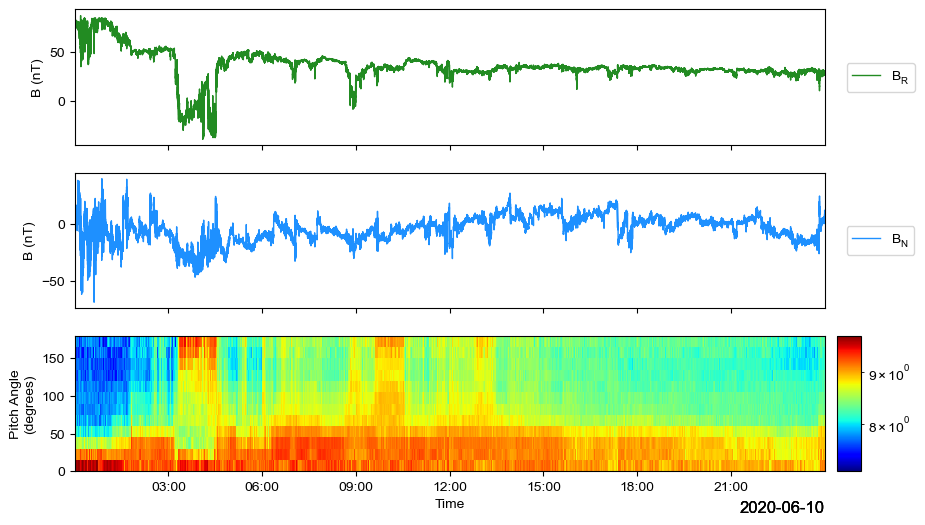

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubby ===
[CUBBY] GRAB CALLER: /Users/robertalexander/GitHub/Plotbot/plotbot/plotbot_main.py:389
[CUBBY] GRAB SUCCESS - Retrieved mag_rtn_4sa with type <class 'plotbot.data_classes.psp_mag_rtn_4sa.mag_rtn_4sa_class'>
[CUBBY] [CUBBY_GRAB_RETURN_STATE] Object ID 13061975952 for key 'mag_rtn_4sa'. dt_len: 5140772, min: 2020-01-28T00:00:00.074993408, max: 2020-09-30T23:59:59.833505024
[CUBBY] GRAB OUTPUT - datetime_array type=ndarray, elem_type=datetime64, shape=(5140772,), range=2020-01-28T00:00:00.074993 to 2020-09-30T23:59:59.833505
[CUBBY] GRAB OUTPUT - raw_data keys=['bt', 'pmag', 'bmag', 'bn', 'br', 'all'] | bt: type=ndarray, shape=(5140772,) | pmag: type=ndarray, shape=(5140772,) | bmag: type=ndarray, shape=(5140772,) | bn: type=ndarray, shape=(5140772,) | br: type=ndarray, shape=(5140772,) | all(list): len=3, elem_shape=(5140772,)
[CUBBY] === End Retrieval Debug (LEAVING DATA CUBBY)===

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubb

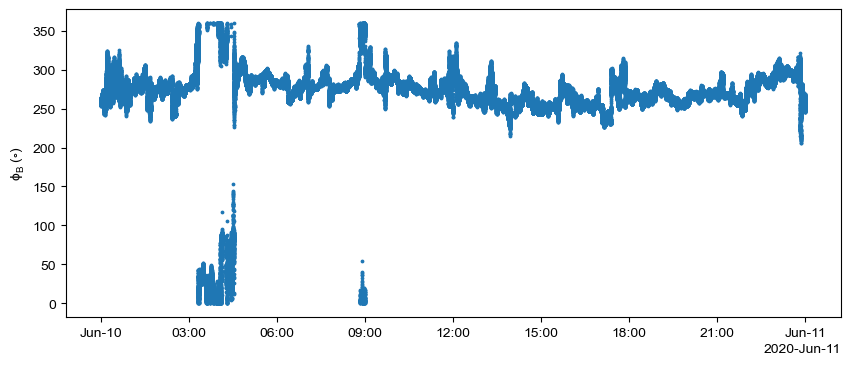

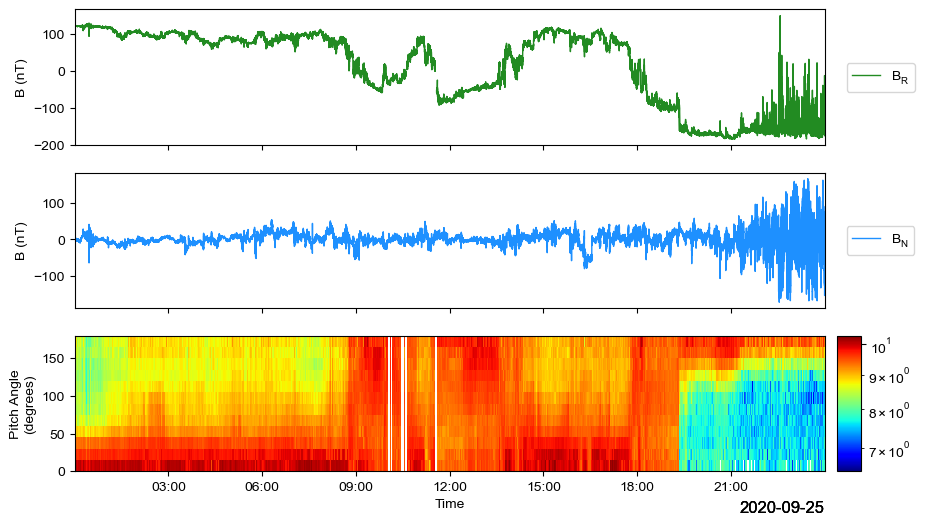

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubby ===
[CUBBY] GRAB CALLER: /Users/robertalexander/GitHub/Plotbot/plotbot/plotbot_main.py:389
[CUBBY] GRAB SUCCESS - Retrieved mag_rtn_4sa with type <class 'plotbot.data_classes.psp_mag_rtn_4sa.mag_rtn_4sa_class'>
[CUBBY] [CUBBY_GRAB_RETURN_STATE] Object ID 13061975952 for key 'mag_rtn_4sa'. dt_len: 5140772, min: 2020-01-28T00:00:00.074993408, max: 2020-09-30T23:59:59.833505024
[CUBBY] GRAB OUTPUT - datetime_array type=ndarray, elem_type=datetime64, shape=(5140772,), range=2020-01-28T00:00:00.074993 to 2020-09-30T23:59:59.833505
[CUBBY] GRAB OUTPUT - raw_data keys=['bt', 'pmag', 'bmag', 'bn', 'br', 'all'] | bt: type=ndarray, shape=(5140772,) | pmag: type=ndarray, shape=(5140772,) | bmag: type=ndarray, shape=(5140772,) | bn: type=ndarray, shape=(5140772,) | br: type=ndarray, shape=(5140772,) | all(list): len=3, elem_shape=(5140772,)
[CUBBY] === End Retrieval Debug (LEAVING DATA CUBBY)===

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubb

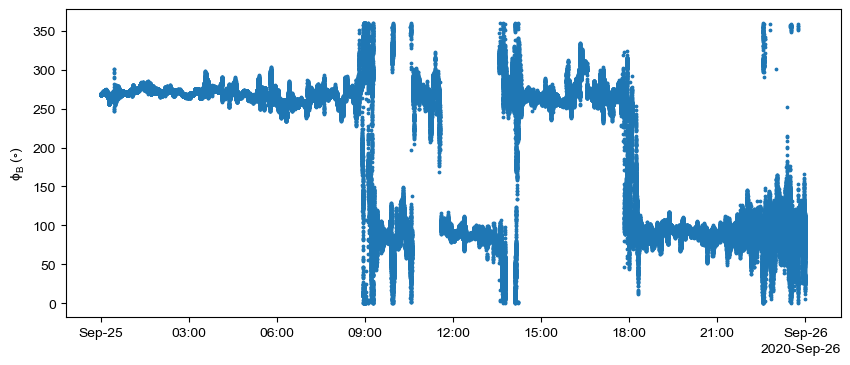

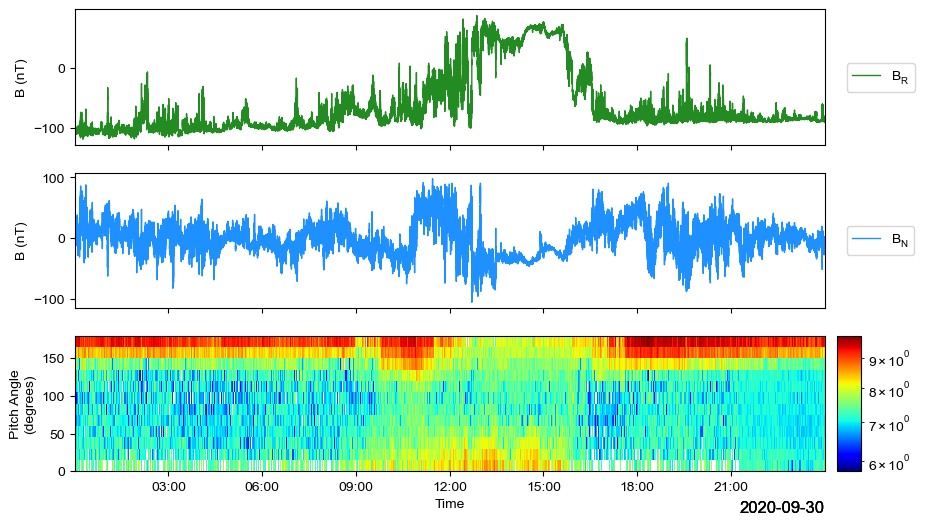

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubby ===
[CUBBY] GRAB CALLER: /Users/robertalexander/GitHub/Plotbot/plotbot/plotbot_main.py:389
[CUBBY] GRAB SUCCESS - Retrieved mag_rtn_4sa with type <class 'plotbot.data_classes.psp_mag_rtn_4sa.mag_rtn_4sa_class'>
[CUBBY] [CUBBY_GRAB_RETURN_STATE] Object ID 13061975952 for key 'mag_rtn_4sa'. dt_len: 5140772, min: 2020-01-28T00:00:00.074993408, max: 2020-09-30T23:59:59.833505024
[CUBBY] GRAB OUTPUT - datetime_array type=ndarray, elem_type=datetime64, shape=(5140772,), range=2020-01-28T00:00:00.074993 to 2020-09-30T23:59:59.833505
[CUBBY] GRAB OUTPUT - raw_data keys=['bt', 'pmag', 'bmag', 'bn', 'br', 'all'] | bt: type=ndarray, shape=(5140772,) | pmag: type=ndarray, shape=(5140772,) | bmag: type=ndarray, shape=(5140772,) | bn: type=ndarray, shape=(5140772,) | br: type=ndarray, shape=(5140772,) | all(list): len=3, elem_shape=(5140772,)
[CUBBY] === End Retrieval Debug (LEAVING DATA CUBBY)===

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubb

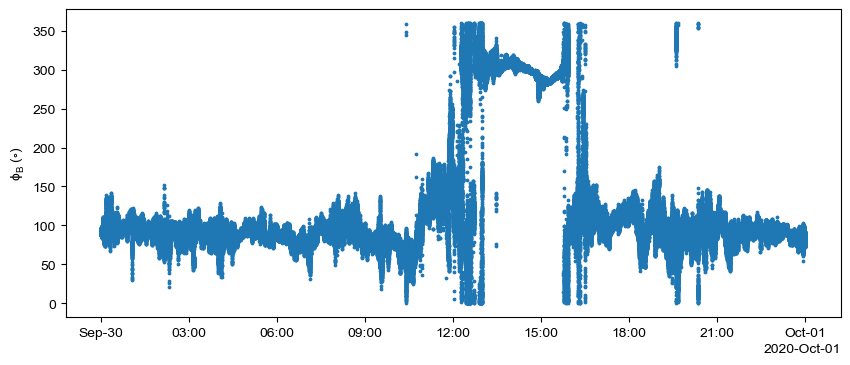

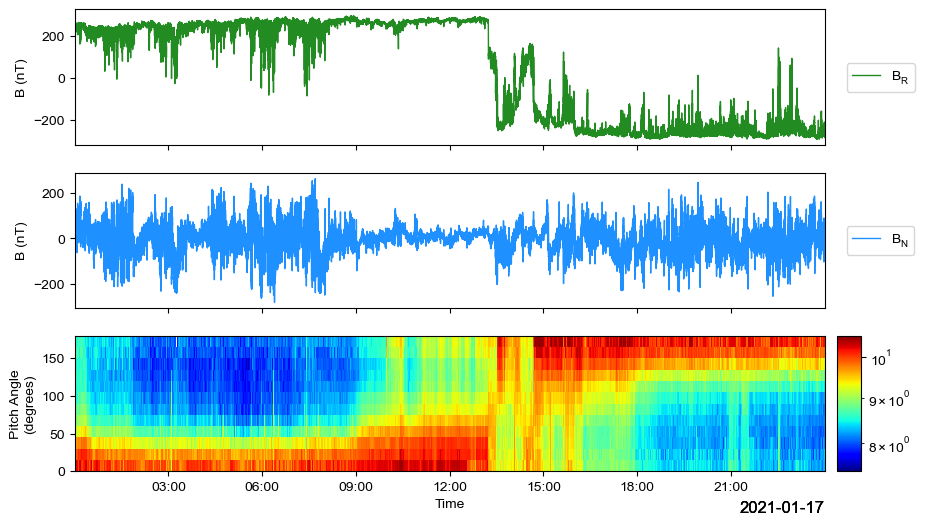

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubby ===
[CUBBY] GRAB CALLER: /Users/robertalexander/GitHub/Plotbot/plotbot/plotbot_main.py:389
[CUBBY] GRAB SUCCESS - Retrieved mag_rtn_4sa with type <class 'plotbot.data_classes.psp_mag_rtn_4sa.mag_rtn_4sa_class'>
[CUBBY] [CUBBY_GRAB_RETURN_STATE] Object ID 13061975952 for key 'mag_rtn_4sa'. dt_len: 5536279, min: 2020-01-28T00:00:00.074993408, max: 2021-01-17T23:59:59.958033024
[CUBBY] GRAB OUTPUT - datetime_array type=ndarray, elem_type=datetime64, shape=(5536279,), range=2020-01-28T00:00:00.074993 to 2021-01-17T23:59:59.958033
[CUBBY] GRAB OUTPUT - raw_data keys=['bt', 'pmag', 'bmag', 'bn', 'br', 'all'] | bt: type=ndarray, shape=(5536279,) | pmag: type=ndarray, shape=(5536279,) | bmag: type=ndarray, shape=(5536279,) | bn: type=ndarray, shape=(5536279,) | br: type=ndarray, shape=(5536279,) | all(list): len=3, elem_shape=(5536279,)
[CUBBY] === End Retrieval Debug (LEAVING DATA CUBBY)===

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubb

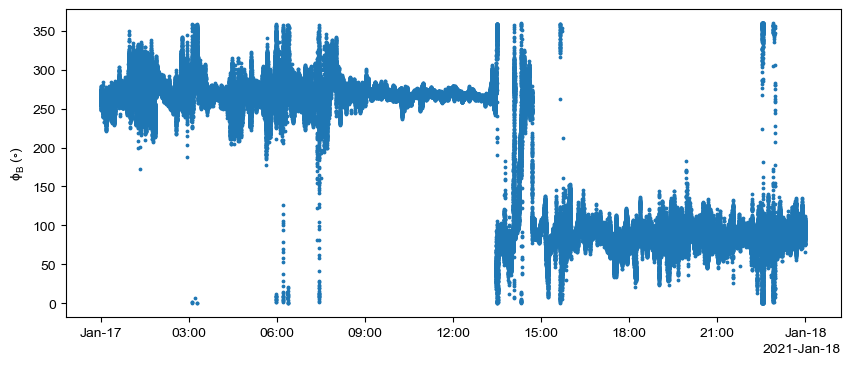

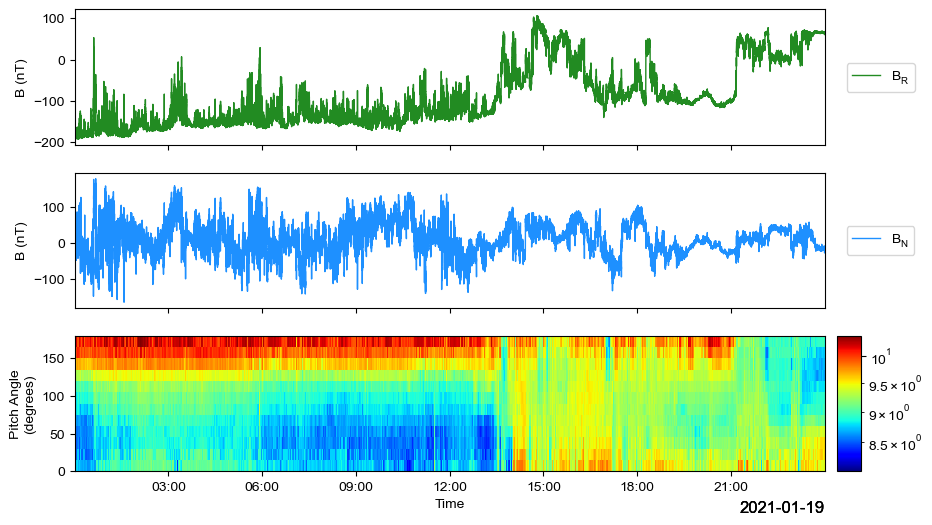

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubby ===
[CUBBY] GRAB CALLER: /Users/robertalexander/GitHub/Plotbot/plotbot/plotbot_main.py:389
[CUBBY] GRAB SUCCESS - Retrieved mag_rtn_4sa with type <class 'plotbot.data_classes.psp_mag_rtn_4sa.mag_rtn_4sa_class'>
[CUBBY] [CUBBY_GRAB_RETURN_STATE] Object ID 13061975952 for key 'mag_rtn_4sa'. dt_len: 5931786, min: 2020-01-28T00:00:00.074993408, max: 2021-01-19T23:59:59.936854784
[CUBBY] GRAB OUTPUT - datetime_array type=ndarray, elem_type=datetime64, shape=(5931786,), range=2020-01-28T00:00:00.074993 to 2021-01-19T23:59:59.936854
[CUBBY] GRAB OUTPUT - raw_data keys=['bt', 'pmag', 'bmag', 'bn', 'br', 'all'] | bt: type=ndarray, shape=(5931786,) | pmag: type=ndarray, shape=(5931786,) | bmag: type=ndarray, shape=(5931786,) | bn: type=ndarray, shape=(5931786,) | br: type=ndarray, shape=(5931786,) | all(list): len=3, elem_shape=(5931786,)
[CUBBY] === End Retrieval Debug (LEAVING DATA CUBBY)===

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubb

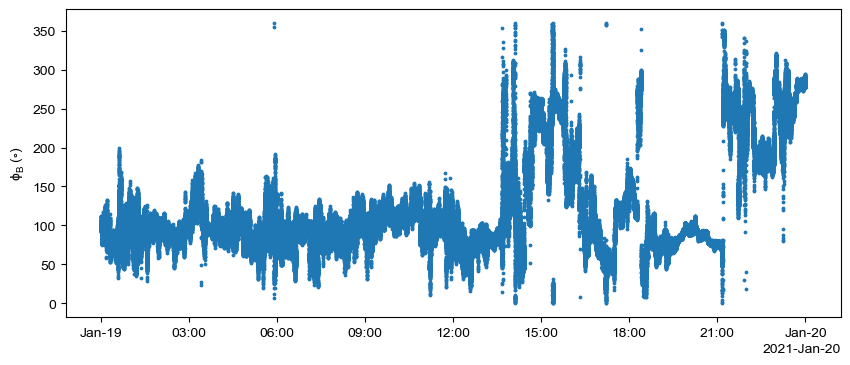

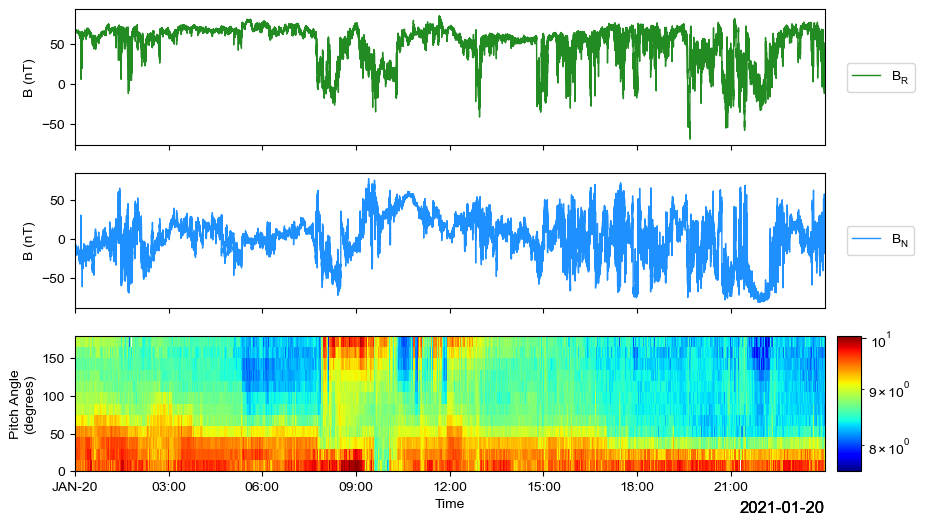

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubby ===
[CUBBY] GRAB CALLER: /Users/robertalexander/GitHub/Plotbot/plotbot/plotbot_main.py:389
[CUBBY] GRAB SUCCESS - Retrieved mag_rtn_4sa with type <class 'plotbot.data_classes.psp_mag_rtn_4sa.mag_rtn_4sa_class'>
[CUBBY] [CUBBY_GRAB_RETURN_STATE] Object ID 13061975952 for key 'mag_rtn_4sa'. dt_len: 6327293, min: 2020-01-28T00:00:00.074993408, max: 2021-01-20T23:59:59.968285440
[CUBBY] GRAB OUTPUT - datetime_array type=ndarray, elem_type=datetime64, shape=(6327293,), range=2020-01-28T00:00:00.074993 to 2021-01-20T23:59:59.968285
[CUBBY] GRAB OUTPUT - raw_data keys=['bt', 'pmag', 'bmag', 'bn', 'br', 'all'] | bt: type=ndarray, shape=(6327293,) | pmag: type=ndarray, shape=(6327293,) | bmag: type=ndarray, shape=(6327293,) | bn: type=ndarray, shape=(6327293,) | br: type=ndarray, shape=(6327293,) | all(list): len=3, elem_shape=(6327293,)
[CUBBY] === End Retrieval Debug (LEAVING DATA CUBBY)===

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubb

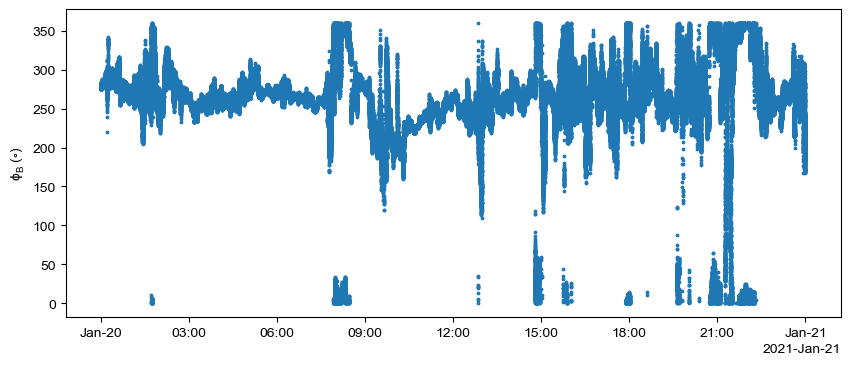

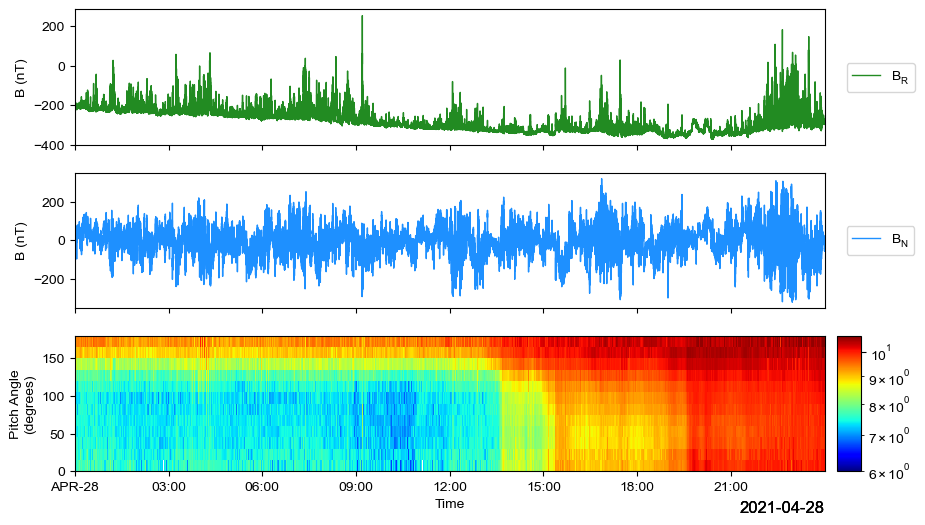

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubby ===
[CUBBY] GRAB CALLER: /Users/robertalexander/GitHub/Plotbot/plotbot/plotbot_main.py:389
[CUBBY] GRAB SUCCESS - Retrieved mag_rtn_4sa with type <class 'plotbot.data_classes.psp_mag_rtn_4sa.mag_rtn_4sa_class'>
[CUBBY] [CUBBY_GRAB_RETURN_STATE] Object ID 13061975952 for key 'mag_rtn_4sa'. dt_len: 6722799, min: 2020-01-28T00:00:00.074993408, max: 2021-04-28T23:59:59.847719680
[CUBBY] GRAB OUTPUT - datetime_array type=ndarray, elem_type=datetime64, shape=(6722799,), range=2020-01-28T00:00:00.074993 to 2021-04-28T23:59:59.847719
[CUBBY] GRAB OUTPUT - raw_data keys=['bt', 'pmag', 'bmag', 'bn', 'br', 'all'] | bt: type=ndarray, shape=(6722799,) | pmag: type=ndarray, shape=(6722799,) | bmag: type=ndarray, shape=(6722799,) | bn: type=ndarray, shape=(6722799,) | br: type=ndarray, shape=(6722799,) | all(list): len=3, elem_shape=(6722799,)
[CUBBY] === End Retrieval Debug (LEAVING DATA CUBBY)===

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubb

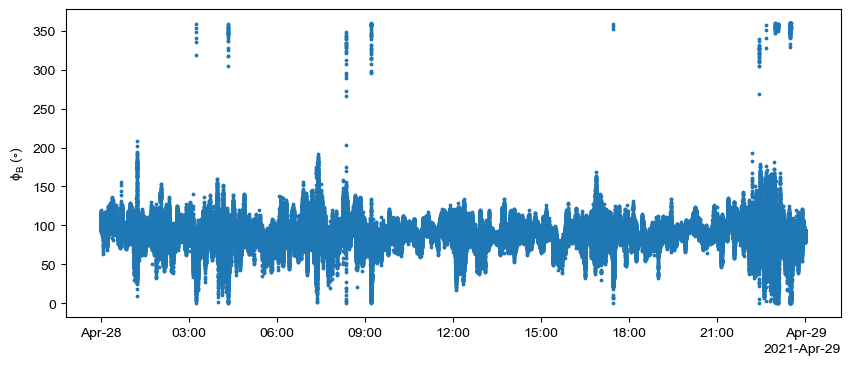

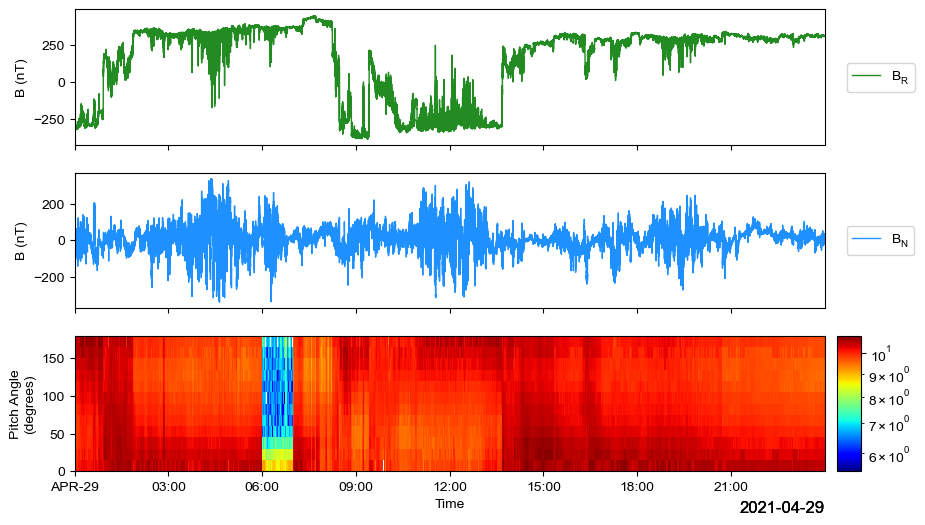

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubby ===
[CUBBY] GRAB CALLER: /Users/robertalexander/GitHub/Plotbot/plotbot/plotbot_main.py:389
[CUBBY] GRAB SUCCESS - Retrieved mag_rtn_4sa with type <class 'plotbot.data_classes.psp_mag_rtn_4sa.mag_rtn_4sa_class'>
[CUBBY] [CUBBY_GRAB_RETURN_STATE] Object ID 13061975952 for key 'mag_rtn_4sa'. dt_len: 7118305, min: 2020-01-28T00:00:00.074993408, max: 2021-04-29T23:59:59.828731904
[CUBBY] GRAB OUTPUT - datetime_array type=ndarray, elem_type=datetime64, shape=(7118305,), range=2020-01-28T00:00:00.074993 to 2021-04-29T23:59:59.828731
[CUBBY] GRAB OUTPUT - raw_data keys=['bt', 'pmag', 'bmag', 'bn', 'br', 'all'] | bt: type=ndarray, shape=(7118305,) | pmag: type=ndarray, shape=(7118305,) | bmag: type=ndarray, shape=(7118305,) | bn: type=ndarray, shape=(7118305,) | br: type=ndarray, shape=(7118305,) | all(list): len=3, elem_shape=(7118305,)
[CUBBY] === End Retrieval Debug (LEAVING DATA CUBBY)===

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubb

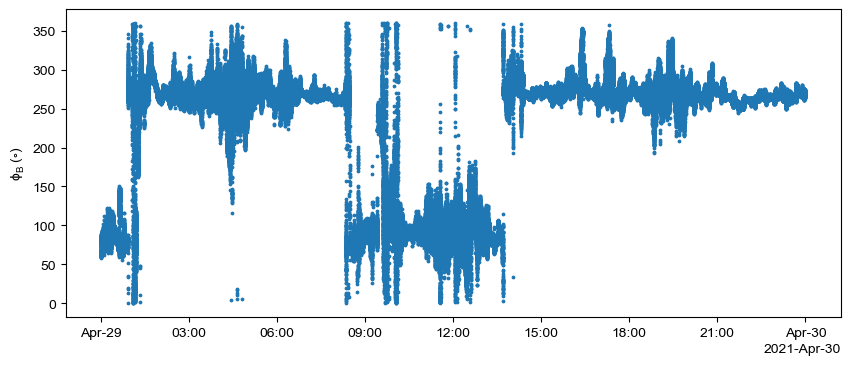

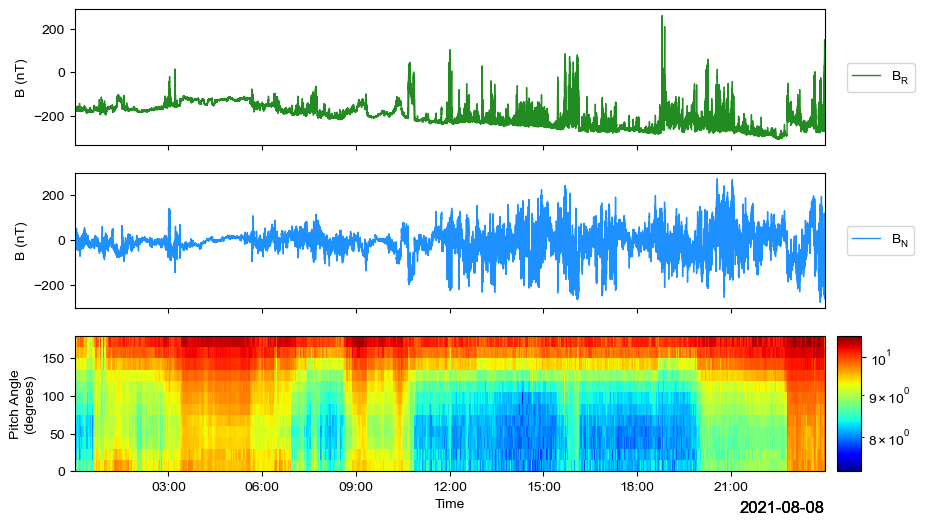

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubby ===
[CUBBY] GRAB CALLER: /Users/robertalexander/GitHub/Plotbot/plotbot/plotbot_main.py:389
[CUBBY] GRAB SUCCESS - Retrieved mag_rtn_4sa with type <class 'plotbot.data_classes.psp_mag_rtn_4sa.mag_rtn_4sa_class'>
[CUBBY] [CUBBY_GRAB_RETURN_STATE] Object ID 13061975952 for key 'mag_rtn_4sa'. dt_len: 7513811, min: 2020-01-28T00:00:00.074993408, max: 2021-08-08T23:59:59.856479872
[CUBBY] GRAB OUTPUT - datetime_array type=ndarray, elem_type=datetime64, shape=(7513811,), range=2020-01-28T00:00:00.074993 to 2021-08-08T23:59:59.856479
[CUBBY] GRAB OUTPUT - raw_data keys=['bt', 'pmag', 'bmag', 'bn', 'br', 'all'] | bt: type=ndarray, shape=(7513811,) | pmag: type=ndarray, shape=(7513811,) | bmag: type=ndarray, shape=(7513811,) | bn: type=ndarray, shape=(7513811,) | br: type=ndarray, shape=(7513811,) | all(list): len=3, elem_shape=(7513811,)
[CUBBY] === End Retrieval Debug (LEAVING DATA CUBBY)===

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubb

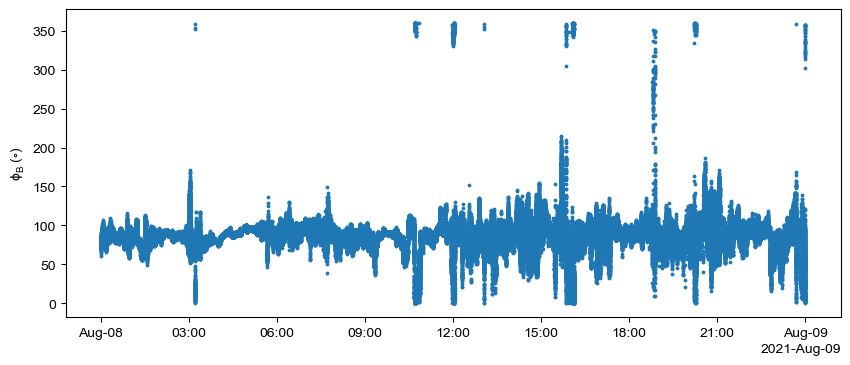

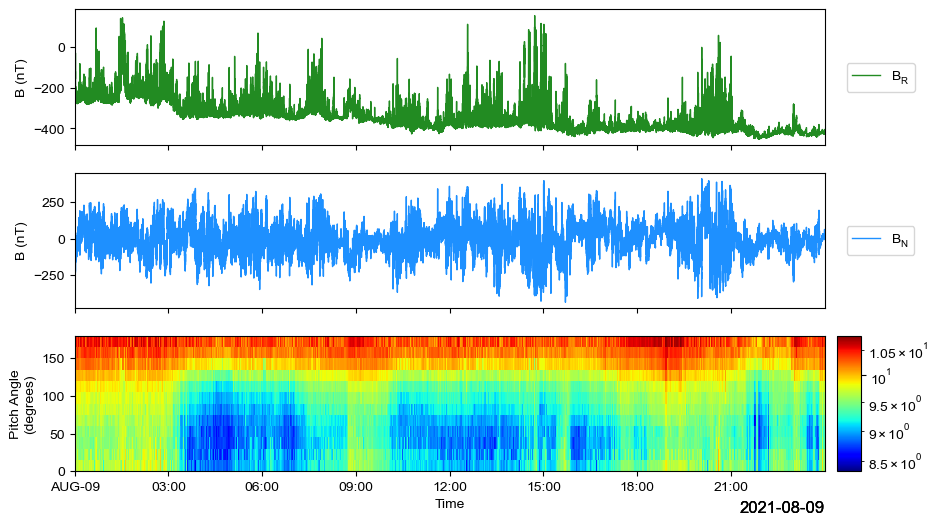

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubby ===
[CUBBY] GRAB CALLER: /Users/robertalexander/GitHub/Plotbot/plotbot/plotbot_main.py:389
[CUBBY] GRAB SUCCESS - Retrieved mag_rtn_4sa with type <class 'plotbot.data_classes.psp_mag_rtn_4sa.mag_rtn_4sa_class'>
[CUBBY] [CUBBY_GRAB_RETURN_STATE] Object ID 13061975952 for key 'mag_rtn_4sa'. dt_len: 7909317, min: 2020-01-28T00:00:00.074993408, max: 2021-08-09T23:59:59.832805248
[CUBBY] GRAB OUTPUT - datetime_array type=ndarray, elem_type=datetime64, shape=(7909317,), range=2020-01-28T00:00:00.074993 to 2021-08-09T23:59:59.832805
[CUBBY] GRAB OUTPUT - raw_data keys=['bt', 'pmag', 'bmag', 'bn', 'br', 'all'] | bt: type=ndarray, shape=(7909317,) | pmag: type=ndarray, shape=(7909317,) | bmag: type=ndarray, shape=(7909317,) | bn: type=ndarray, shape=(7909317,) | br: type=ndarray, shape=(7909317,) | all(list): len=3, elem_shape=(7909317,)
[CUBBY] === End Retrieval Debug (LEAVING DATA CUBBY)===

[CUBBY] 
=== Retrieving mag_rtn_4sa from data_cubb

KeyboardInterrupt: 

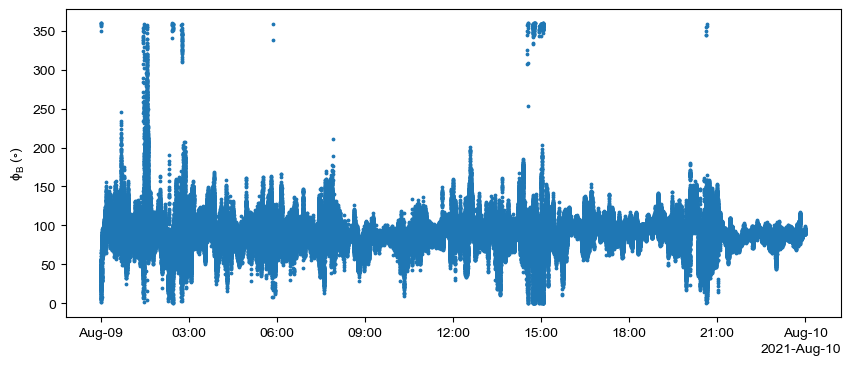

In [ ]:
### Jaye's conjunction jambalaya

plotbot.print_manager.show_status = False
plotbot.print_manager.show_debug = False
plotbot.print_manager.show_data_cubby = True

conjumble = [['2020-01-28', '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02'], #E4
['2020-06-06','2020-06-07','2020-06-08','2020-06-09','2020-06-10'], #E5
['2020-09-25','2020-09-30'], #E6
['2021-01-17','2021-01-19','2021-01-20'], #E7
['2021-04-28','2021-04-29'], #E8gr8
['2021-08-08','2021-08-09','2021-08-10','2021-08-11'], #E9
['2021-11-22'], #E10
['2022-02-25'], #E11
['2022-06-02', '2022-06-03'], #E12
['2022-09-04','2022-09-05','2022-09-06'], #E13
['2022-12-12'], #E14
['2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-18'], #E15
['2023-06-21','2023-06-22'], #E16
['2023-09-26', '2023-09-27', '2023-09-28'], #E17
['2023-12-29'], #E18
['2024-03-29', '2024-03-30'], #E19
['2024-06-24','2024-06-25','2024-06-28','2024-06-29','2024-06-30','2024-07-01','2024-07-02','2024-07-03','2024-07-04'], #E20
['2024-09-26','2024-09-28','2024-09-29','2024-09-30','2024-10-01','2024-10-02','2024-10-04'], #E21
['2024-12-23','2024-12-24','2024-12-25'], #E22
['2025-03,19','2025-03-21','2025-03-22','2025-03-23','2025-03-27','2025-03-28'] #E23
]

## 1. Get set of days associated with each encounter
for enc in conjumble:
    for i in range(len(enc)):
        date = enc[i]
        y = int(date[0:4])
        m = int(date[5:7])
        d = int(date[8:10])

        y_str = date[0:4]
        m_str = date[5:7]
        d_str = date[8:10]

        y_f = y
        m_f = m
        d_f = d + 1

        yf_str = str(y_f)
        if m_f > 9:
            mf_str = str(m_f)
        else:
            mf_str = '0{}'.format(m_f)
            
        if d_f > 9:
            df_str = str(d_f)
        else:
            df_str = '0{}'.format(d_f)

        # If next day is out of bounds, change days
        if m in [4,6,9,11]:
            if d == 30:
                m_f += 1
                d_f = 1
                yf_str = str(y_f)
                if m_f > 9:
                    mf_str = str(m_f)
                else:
                    mf_str = '0{}'.format(m_f)
                df_str = '01'

        elif m in [1,2,3,5,7,8,10]:
            if d == 31:
                m_f += 1
                d_f = 1
                yf_str = str(y_f)
                if m_f > 9:
                    mf_str = str(m_f)
                else:
                    mf_str = '0{}'.format(m_f)
                df_str = '01'

        elif m == 12:
            if d == 31:
                y_f += 1
                m_f = 1
                d_f = 1
                yf_str = str(y_f)
                mf_str = '01'
                df_str = '01'
        

        trange = [y_str + '-' + m_str + '-' + d_str + '/00:00:00.000',yf_str +'-' + mf_str + '-' + df_str + '/00:00:00.000']



        plotbot.ploptions.return_figure = False
        plotbot.ploptions.display_figure = True

        # Before the plotbot call, you need to pass br and bn to get them clipped
        plotbot.plotbot(trange, plotbot.mag_rtn_4sa.br, 1, plotbot.mag_rtn_4sa.bn, 2, plotbot.epad.strahl, 3)

        # NOW these will be clipped to trange:
        tB = np.array(plotbot.mag_rtn_4sa.br.datetime_array)  # Clipped times
        Br = np.array(plotbot.mag_rtn_4sa.br.data)            # Clipped data
        Bn = np.array(plotbot.mag_rtn_4sa.bn.data)            # Clipped data
        phi_B = np.degrees(np.arctan2(Br, Bn)) + 180

        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
        ax.scatter(tB, phi_B, s=3)
        ax.set_ylabel(r'$\phi_B \ (\circ)$')